# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [236]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import pylab
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact

In [237]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("mapbox")

# Import Data

In [238]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [239]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    house_units_yr = sfo_data["housing_units"]
    house_units_yr = house_units_yr.groupby([sfo_data.index]).mean()
    house_units_yr_fig = plt.figure()
    house_units_plot = house_units_yr.plot.bar(x='year', ylim=[370000, 385000], title="Average Number of Housing Units Sold/Year")
    plt.close(house_units_yr_fig)
    
    return pn.pane.Matplotlib(house_units_yr_fig)

In [240]:
def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    average_gross_rent1 = pd.DataFrame(sfo_data.groupby(['year']).mean()['gross_rent'])
    
    average_gross_rent_plot = average_gross_rent1.hvplot(title ='Average gross rent per Year')
    
      
   
    return average_gross_rent_plot

In [241]:
def average_sales_price():
    """Average Sales Price Per Year."""
    avg_price_sqr_foot = sfo_data["sale_price_sqr_foot"].groupby([sfo_data.index]).mean()
    sales_price_fig = plt.figure()
    avg_price_plot = (avg_price_sqr_foot.plot.line(x='year', y='sale_price_sqr_foot', title="Average Sales Price/Year"))
    plt.close(sales_price_fig)
    
    return pn.pane.Matplotlib(sales_price_fig)

In [242]:
def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    df_price = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    df_price.reset_index(inplace=True)
    df_price.rename(columns={"level_0": "year"}, inplace=True)
    average_price_by_neighborhood_plot = df_price.hvplot.line(
    "year",
    "sale_price_sqr_foot",
    xlabel="Year",
    ylabel="Avg. Sale Price per Square Foot",
    groupby="neighborhood",)
    
    return average_price_by_neighborhood_plot

In [243]:
def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    avg_value_per_neighborhood = sfo_data.groupby([sfo_data["neighborhood"]]).mean()
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    ten_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    ten_plot = px.bar(ten_most_expensive,
    x="neighborhood", 
    y="sale_price_sqr_foot", 
    title="Ten Most Expensive Neighborhoods in San Francisco", 
    )

    return ten_plot

In [244]:
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    avg_value_per_neighborhood = sfo_data.groupby([sfo_data["neighborhood"]]).mean(0)
    ten_most_expensive = avg_value_per_neighborhood.nlargest(10, "sale_price_sqr_foot").reset_index()
    ten_parallel = px.parallel_coordinates(
    ten_most_expensive,
    color="sale_price_sqr_foot")
    
    return ten_parallel

In [245]:
def parallel_categories():
    """Parallel Categories Plot."""
    avg_value_per_neighborhood = sfo_data.groupby([sfo_data["neighborhood"]]).mean()  
    ten_exp_neighborhood = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    ten_parallel_categories = px.parallel_categories(
    ten_exp_neighborhood,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
)

    return ten_parallel_categories

In [246]:
def neighborhood_map():
    """Neighborhood Map"""
    file_path = Path("Data/neighborhoods_coordinates.csv")
    df_neighborhood_location = pd.read_csv(file_path)
    avg_value_per_neighborhood = sfo_data.groupby([sfo_data["neighborhood"]]).mean()  
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    avg_value_location = pd.concat([avg_value_per_neighborhood, df_neighborhood_location], axis="columns", join="inner")

    location_map = px.scatter_mapbox(
    avg_value_location,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    color_continuous_scale=px.colors.cyclical.IceFire,
    #title="Avg Sale Price per Square Foot and Gross Rent in San Fran",
    zoom=11,
    width=800,
)
    

    return location_map

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [247]:
# Create a Title for the Dashboard
title = '#San Fran Real Estate Analysis'
welcome = pn.pane.Markdown("San Fran historical house prices")

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("Welcome", pn.Column(welcome, neighborhood_map())),
    ("Yearly Mkt Analysis", pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())),
    ("Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods())),
    (
        "Parallel Plot Analysis",
        pn.Column(pn.Row(title), tabs, width=800)
    ),
)
panel = pn.Column(pn.Row(title), tabs, width=800)

## Serve the Panel Dashboard

Column(width=800)
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] HoloViews(Curve)
            [2] Matplotlib(Figure)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] Plotly(Figure)
        [3] Column(width=800)
            [0] Row
                [0] Markdown(str)
            [1] Tabs
                [0] Column
                    [0] Markdown(str)
                    [1] Plotly(Figure, relayout_data={'mapbox.center': {'lon': ...})
                [1] Row
                    [0] Matplotlib(Figure)
                    [1] HoloViews(Curve)
                    [2] Matplotlib(Figure)
                [2] Column
                    [0] Row
                        [0] HoloViews(DynamicMap)
                        [1] Column
                            [0] WidgetBox
                                [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                            [1] VSpacer()
                    [1] Plotly(Figure, relayout_data={'autosize': True}, viewport={'xaxis.range': [-0.5, ...})
                [3] Column(width=800)
                    [0] Row
                        [0] Markdown(str)
                    [1] Tabs
                        [0] Column
                            [0] Markdown(str)
                            [1] Plotly(Figure, relayout_data={'autosize': True})
                        [1] Row
                            [0] Matplotlib(Figure)
                            [1] HoloViews(Curve)
                            [2] Matplotlib(Figure)
                        [2] Column
                            [0] Row
                                [0] HoloViews(DynamicMap)
                                [1] Column
                                    [0] WidgetBox
                                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                                    [1] VSpacer()
                            [1] Plotly(Figure, relayout_data={'autosize': True}, viewport={'xaxis.range': [-0.5, ...})
                        [3] Column(width=800)
                            [0] Row
                                [0] Markdown(str)
                            [1] Tabs
                                [0] Column
                                    [0] Markdown(str)
                                    [1] Plotly(Figure, relayout_data={'mapbox.center': {'lon': ...})
                                [1] Row
                                    [0] Matplotlib(Figure)
                                    [1] HoloViews(Curve)
                                    [2] HoloViews(Curve)
                                [2] Column
                                    [0] Row
                                        [0] HoloViews(DynamicMap)
                                        [1] Column
                                            [0] ...
                                            [1] VSpacer()
                                    [1] HoloViews(Bars)
                                [3] Column(width=960)
                                    [0] Plotly(Figure, relayout_data={'autosize': True})
                                    [1] Plotly(Figure, relayout_data={'autosize': True})
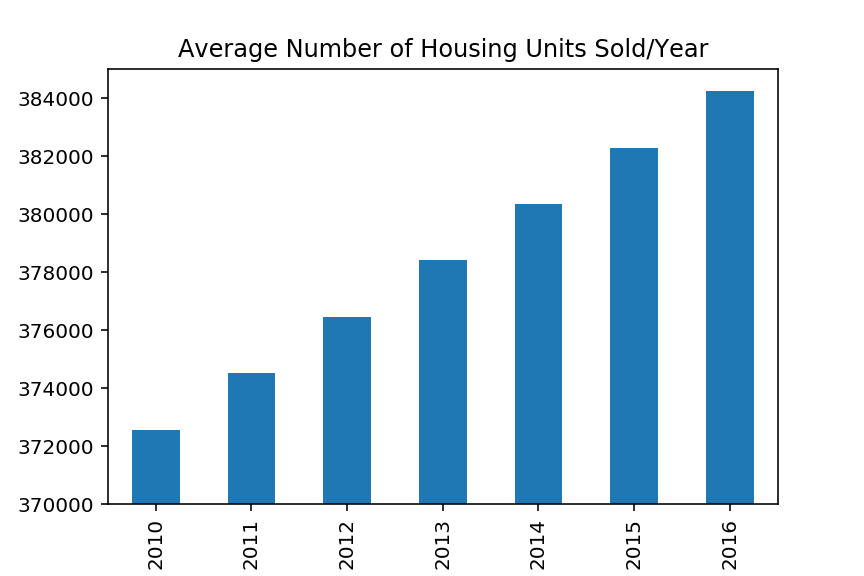
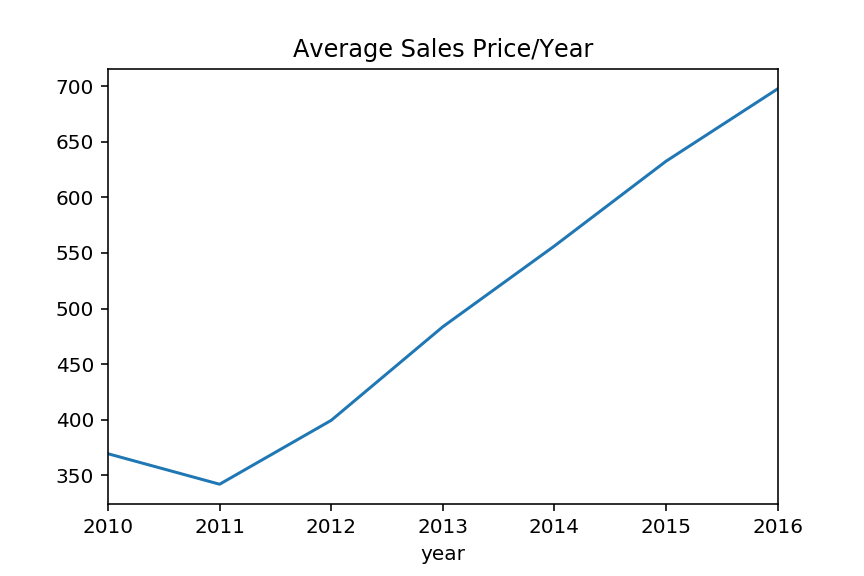
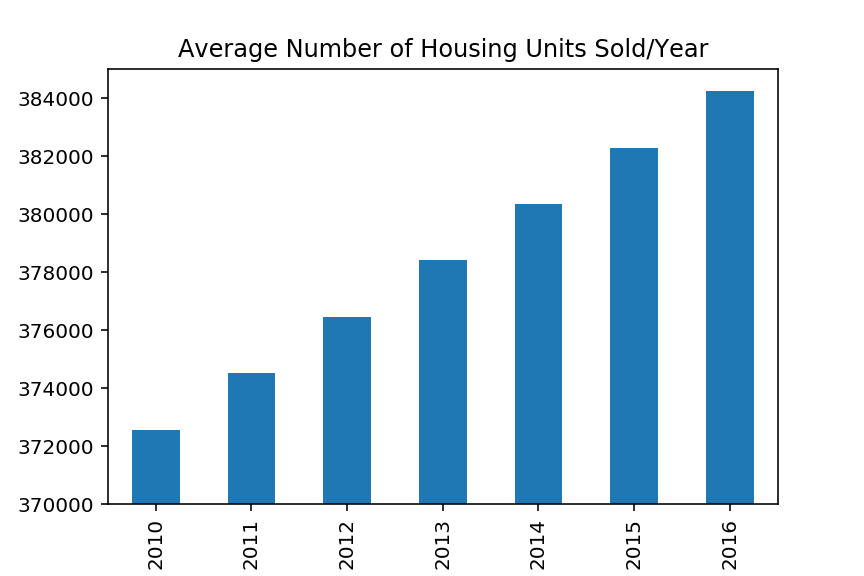
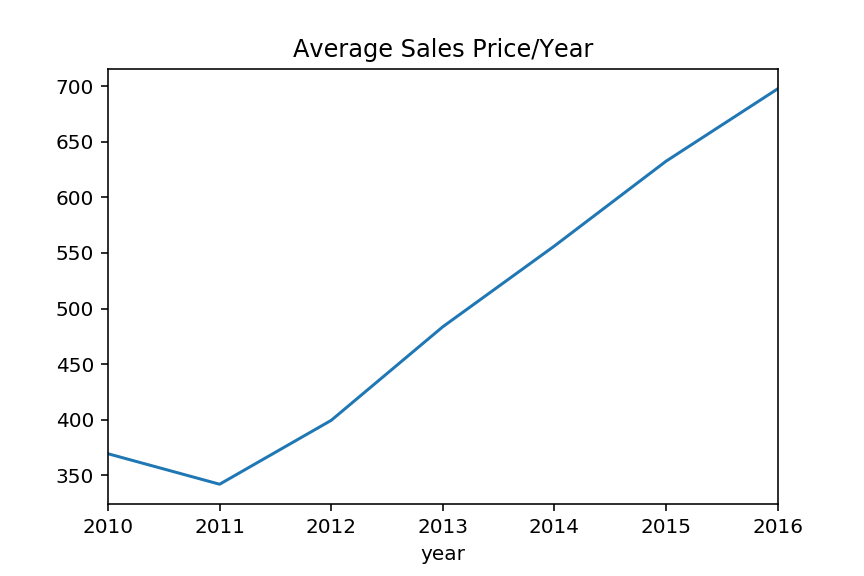
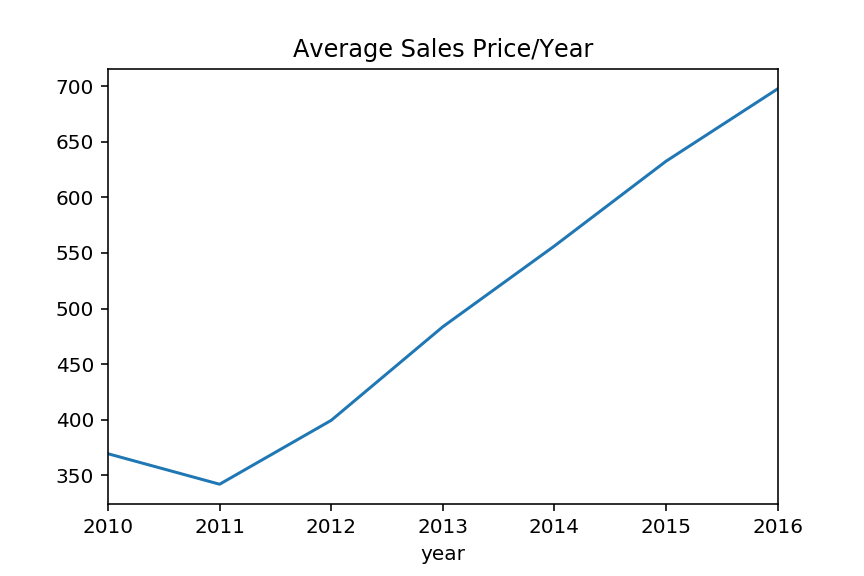
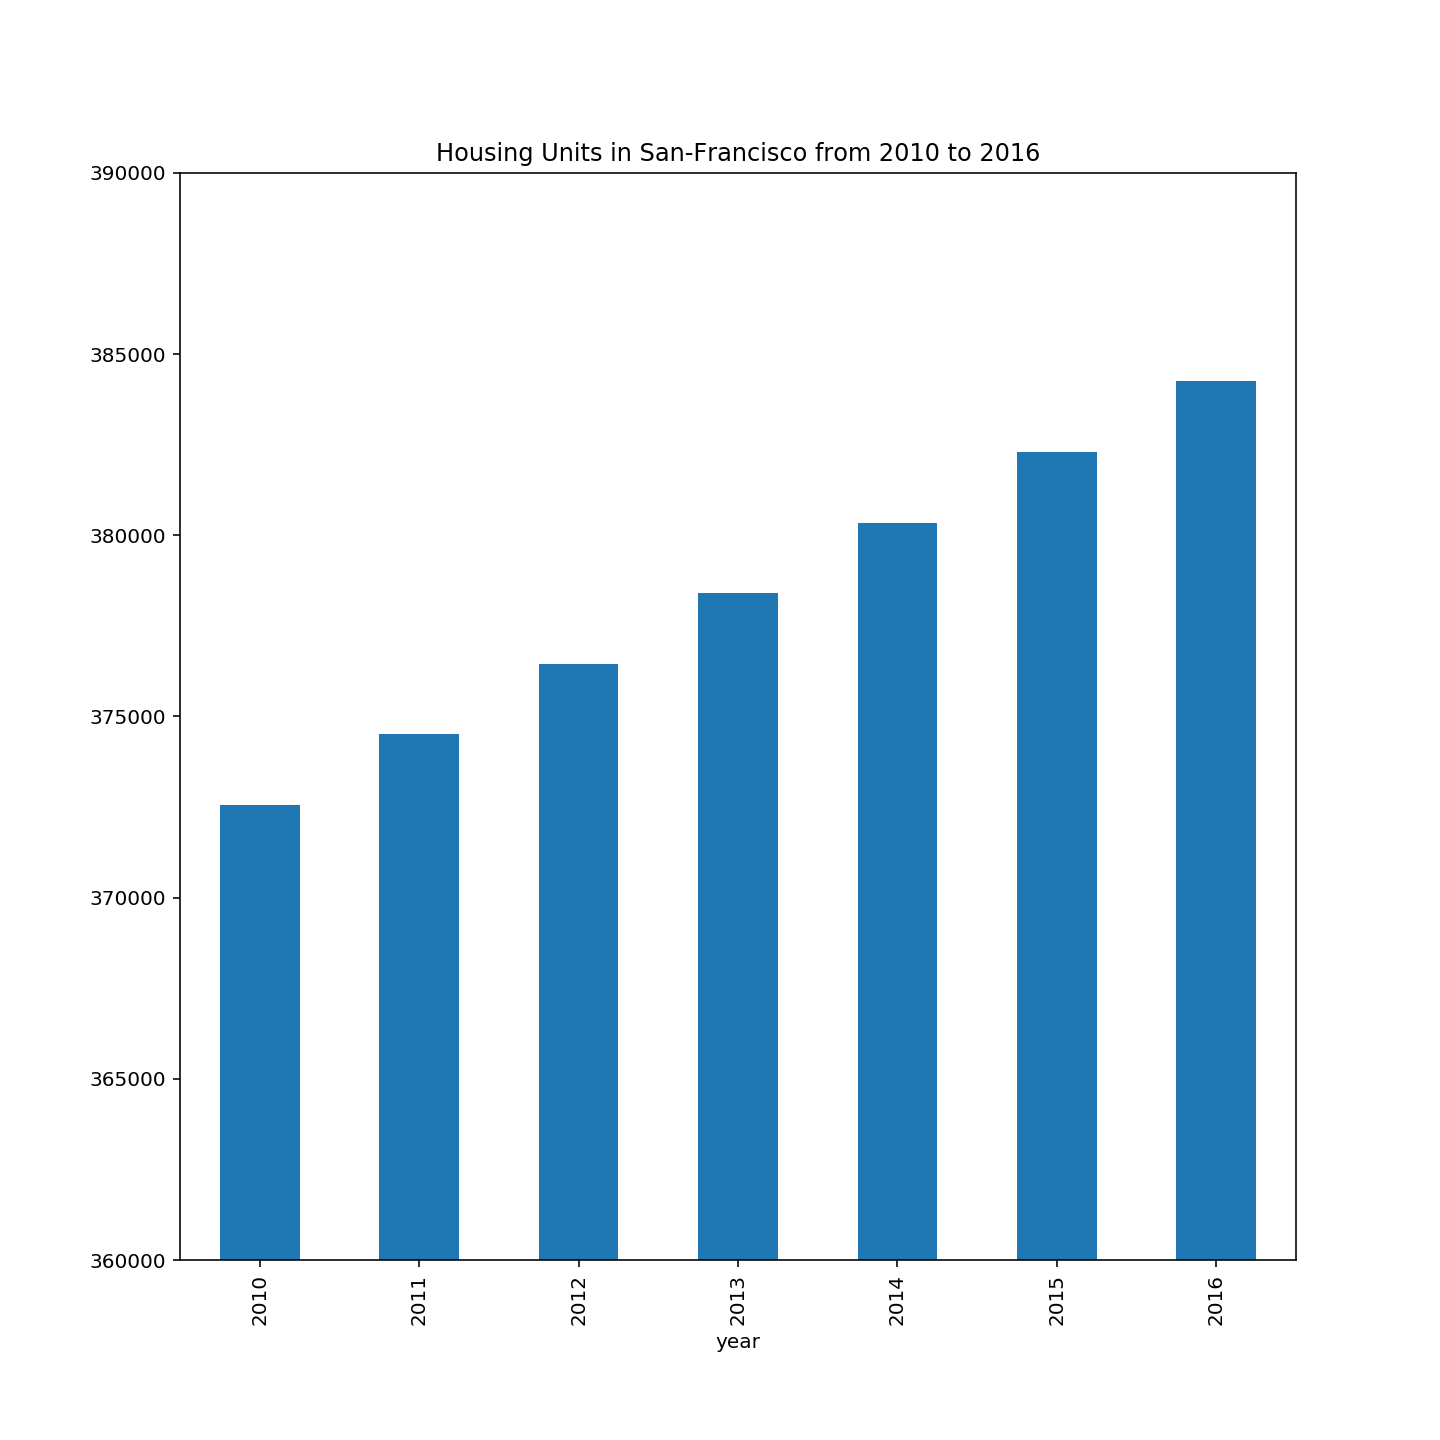
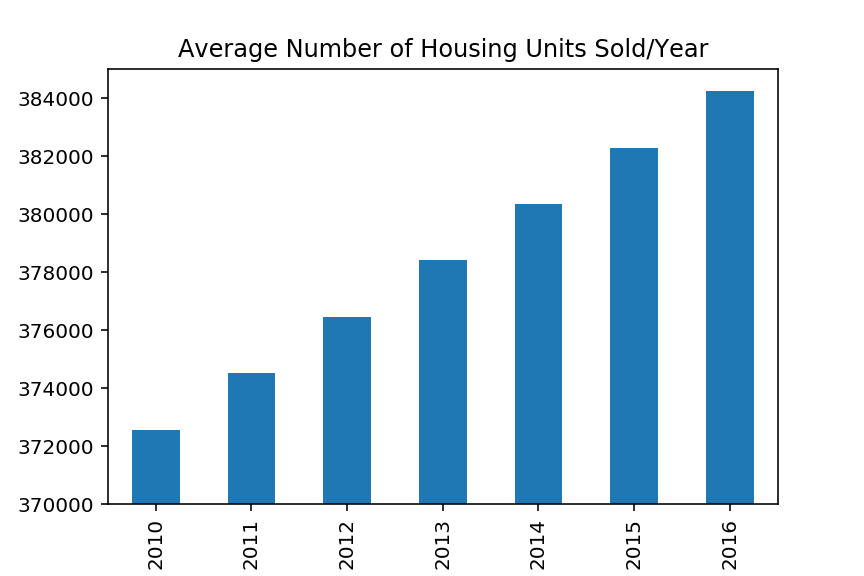

In [248]:
panel.servable()